In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.0


# Model subclassing and custom training loops

 ## Coding tutorials
 #### [1. Model subclassing](#coding_tutorial_1)
 #### [2. Custom layers](#coding_tutorial_2)
 #### [3. Automatic differentiation](#coding_tutorial_3)
 #### [4. Custom training loops](#coding_tutorial_4)
 #### [5. tf.function decorator](#coding_tutorial_5)

***
<a id="coding_tutorial_1"></a>
## Model subclassing

In [2]:
import numpy as  np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Softmax, concatenate, InputLayer, Input

#### Create a simple model using the model subclassing API

In [3]:
# Build the model

class MyModel(Model):
    def __init__(self, i_size, classes):
        super(MyModel, self).__init__()
        self.input_1 = InputLayer(input_shape=i_size)
        self.dense_1 = Dense(units=64, activation="relu")
        self.dout_1 =  Dropout(rate=0.5)
        self.dense_2 = Dense(units=classes, activation="softmax")

    def call(self, data, training=False):
        h = self.input_1(data)
        h = self.dense_1(h)
        h = self.dout_1(h, training)
        return self.dense_2(h)

In [4]:
# Print the model summary

model = MyModel(i_size=(40), classes=10)

model(tf.random.normal(shape=(4, 40), mean=0, stddev=1.0))
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
dense (Dense)                multiple                  2624      
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense_1 (Dense)              multiple                  650       
Total params: 3,274
Trainable params: 3,274
Non-trainable params: 0
_________________________________________________________________


***
<a id="coding_tutorial_2"></a>
## Custom layers

In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax

#### Create custom layers

In [6]:
# Create a custom layer

class MyLayer(Layer):
    def __init__(self, units, input_dim):
        super(MyLayer, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal")
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=False)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b

In [7]:
# Specify trainable weights

my_dense = MyLayer(units=2, input_dim=5)

print("Output:\n{}".format(my_dense(tf.random.normal(shape=(4, 5), mean=0, stddev=1.0).numpy())))
print("\n")
print("Weights:\n{}".format([x for x in my_dense.weights if x.trainable is True]))

Output:
[[ 0.00200713 -0.04902335]
 [ 0.04388793 -0.07413518]
 [ 0.05831473 -0.14500706]
 [ 0.06919327  0.05782203]]


Weights:
[<tf.Variable 'Variable:0' shape=(5, 2) dtype=float32, numpy=
array([[ 0.0196559 , -0.00593896],
       [ 0.03377752,  0.04630087],
       [ 0.05686619,  0.00152219],
       [ 0.04953028, -0.0436723 ],
       [-0.02488605,  0.06981435]], dtype=float32)>]


In [8]:
print('trainable weights:', len(my_dense.trainable_weights))
print('non-trainable weights:', len(my_dense.non_trainable_weights))

trainable weights: 1
non-trainable weights: 1


In [9]:
# Create a custom layer to accumulate means of output values

class MyLayerAccumulator(Layer):
    def __init__(self, units, input_dim):
        super(MyLayerAccumulator, self).__init__()
        self.w = self.add_weight(shape=(input_dim, units), initializer="random_normal")
        self.b = self.add_weight(shape=(units,), initializer="zeros", trainable=False)
        self.sum_activations = tf.Variable(initial_value=tf.zeros(shape=(units,)), trainable=False)
        self.num_calls = tf.Variable(initial_value=0, trainable=False, dtype=tf.float32)

    def call(self, inputs):
        activations = tf.matmul(inputs, self.w) + self.b
        self.sum_activations.assign_add(tf.reduce_sum(activations, axis=0))
        self.num_calls.assign_add(inputs.shape[0])
        return activations, self.sum_activations/self.num_calls

In [10]:
# Test the layer

my_accum = MyLayerAccumulator(5, 5)

y, activation_means = my_accum(tf.ones((10, 5), dtype=tf.float32))
y, activation_means = my_accum(tf.ones((1, 5), dtype=tf.float32))

print("Y:\n", y.numpy().squeeze())
print("\n")
print("Y Rolling Mean:\n", activation_means.numpy())

Y:
 [ 0.01492433  0.01680291  0.0335212   0.02091268 -0.06320038]


Y Rolling Mean:
 [ 0.01492432  0.01680291  0.0335212   0.02091268 -0.06320036]


In [11]:
# Create a Dropout layer as a custom layer

class MyDropout(Layer):

    def __init__(self, rate):
        super(MyDropout, self).__init__()
        self.rate = rate
        
    def call(self, inputs):
        mask = tf.constant(np.random.choice([0,1], size=inputs.shape, p=[self.rate, 1-self.rate]), dtype=tf.float32)
        return mask*inputs

In [12]:
dummy_input = tf.random.normal(shape=(4, 5))

my_dropout = MyDropout(rate=0.2)

print("MY:\n", my_dropout(dummy_input))
print()
print("TF:\n", tf.nn.dropout(dummy_input, rate=0.2))

MY:
 tf.Tensor(
[[-0.7917608  -0.30354717 -0.         -0.93690246  1.3030303 ]
 [ 0.24605748 -0.07812932 -1.1714423  -0.         -0.05424082]
 [ 0.959828   -2.8942873   1.8824849  -0.          0.23338735]
 [-0.09466671  0.5366626  -0.4498653   0.73990065  0.8169496 ]], shape=(4, 5), dtype=float32)

TF:
 tf.Tensor(
[[-0.98970103 -0.37943396 -0.         -0.          1.6287878 ]
 [ 0.30757186 -0.         -1.4643028  -0.         -0.06780102]
 [ 1.199785   -3.6178591   2.353106   -1.163292    0.        ]
 [-0.11833339  0.6708282  -0.          0.9248758   1.0211871 ]], shape=(4, 5), dtype=float32)


#### Implement the custom layers into a model

In [13]:
# Build the model using custom layers with the model subclassing API

class MyModel(Model):

    def __init__(self, units_1, input_dim_1, units_2, units_3):
        super(MyModel, self).__init__()
        self.input_1 = InputLayer(input_shape=input_dim_1)
        self.dense_1 = MyLayer(units=units_1, input_dim=input_dim_1)
        self.dropout_1 = MyDropout(rate=0.5)
        self.dense_2 = MyLayer(units=units_2, input_dim=units_1)
        self.dropout_2 = MyDropout(rate=0.2)
        self.dense_3 = MyLayer(units=units_3, input_dim=units_2)
        self.softmax = Softmax()

    def call(self, inputs):
        h = self.input_1(inputs)
        h = self.dense_1(h)
        h = tf.nn.relu(h)
        h = self.dropout_1(h)
        h = self.dense_2(h)
        h = tf.nn.relu(h)
        h = self.dropout_2(h)
        h = self.dense_3(h)
        return self.softmax(h)

In [14]:
# Instantiate a model object

model = MyModel(units_1 = 64,
                input_dim_1=10000,
                units_2=64,
                units_3=46)

print(model(tf.ones((1, 10000))).numpy(), 
      end="\n\n")
model.summary()

[[0.01724067 0.01843926 0.01684201 0.01830976 0.02318804 0.02062421
  0.03035396 0.03005404 0.01561166 0.01522208 0.01379215 0.02431046
  0.01232434 0.02053166 0.02620127 0.02183533 0.02560571 0.02523084
  0.03262161 0.01950862 0.01241727 0.02390916 0.01454125 0.01861619
  0.0451261  0.01859639 0.02448095 0.02781974 0.01846091 0.0232712
  0.0137255  0.02437336 0.02379769 0.03440738 0.02380098 0.01791074
  0.01481623 0.01275021 0.02848486 0.03272593 0.01599388 0.0277808
  0.01761775 0.02000708 0.01870698 0.01801379]]

Model: "my_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
my_layer_1 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_1 (MyDropout)     multiple                  0     

***
<a id="coding_tutorial_3"></a>
## Automatic differentiation

In [15]:
import numpy as np
import matplotlib.pyplot as plt

#### Create synthetic data

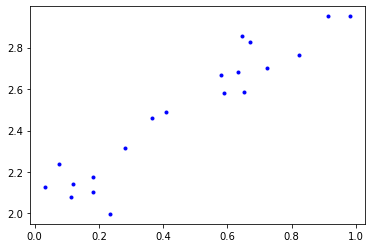

In [16]:
# Create data from a noise contaminated linear model

def MakeNoisyData(m, b, n=20):
    x = tf.random.uniform(shape=(n,1))
    noise = tf.random.normal(shape=(len(x),1), stddev=0.1)
    y = m * x + b + noise
    return x, y

m=1
b=2
x_train, y_train = MakeNoisyData(m,b)
plt.plot(x_train, y_train, 'b.')
plt.show()

#### Define a linear regression model

In [17]:
from tensorflow.keras.layers import Layer

In [18]:
# Build a custom layer for the linear regression model

class MyLinearRegression(Layer):
    def __init__(self, **kwargs):
      super(MyLinearRegression, self).__init__(**kwargs)
    
    def build(self, input_shape, output_dim=1):
      self.w = self.add_weight(
                                shape=(input_shape[-1], output_dim),
                                initializer="random_normal",
                                trainable=True,
                                name="Slope"
                              )
      self.b = self.add_weight(
                                shape=(output_dim,), 
                                initializer="random_normal", 
                                trainable=True,
                                name="Bias"
                              )

    def call(self, inputs):
      return tf.matmul(inputs, self.w) + self.b

In [19]:
lin_reg = MyLinearRegression()

print("Model Output:\n", lin_reg(x_train).numpy().T)
print()
print("Model Weights:")
for x in lin_reg.weights:
    print(x.name, x.numpy())

Model Output:
 [[0.04277422 0.04140233 0.03688009 0.02090327 0.03210534 0.04433976
  0.04120746 0.02426339 0.03891174 0.03522968 0.03891911 0.03050327
  0.02159315 0.01531307 0.01199653 0.0188842  0.00944344 0.02178817
  0.02220376 0.02380811]]

Model Weights:
my_linear_regression/Slope:0 [[-0.03684497]]
my_linear_regression/Bias:0 [0.04558493]


#### Define the loss function

In [20]:
# Define the mean squared error loss function

def SquaredError(y_pred, y_true):
    return tf.reduce_mean(tf.square(y_pred - y_true)) 

starting_loss = SquaredError(lin_reg(x_train), y_train)
print("Starting loss", starting_loss.numpy())

Starting loss 6.135874


#### Train and plot the model

In [21]:
# Implement a gradient descent training loop for the linear regression model

lr = 1.0
steps = 20
sampler_noise = 0.2

grad_hist = [[tf.constant(0.0),tf.constant(0.0)]]
weight_hist = [lin_reg.weights[0].numpy().squeeze()]
bias_hist = [lin_reg.weights[1].numpy().squeeze()]
loss_hist = [starting_loss.numpy()]
lr_hist = [lr]

for i in range(steps):
    with tf.GradientTape() as tape:
        preds = lin_reg(x_train)
        loss = SquaredError(preds, y_train)
    
    # Gradient Estimation
    grad = tape.gradient(loss, lin_reg.trainable_variables)
    
    # Parameter Update in Probabilistic Style
    grad = [tf.random.truncated_normal(shape=grad[0].shape, mean=grad[0][0,0], stddev=sampler_noise),
            tf.random.truncated_normal(shape=grad[1].shape, mean=grad[1][0], stddev=sampler_noise)]
    lin_reg.weights[0].assign_sub(lr*grad[0])
    lin_reg.weights[1].assign_sub(lr*grad[1])

    # Recording Parametrs & Loss
    weight_hist.append(lin_reg.weights[0].numpy().squeeze())
    bias_hist.append(lin_reg.weights[1].numpy().squeeze())
    grad_hist.append(grad)
    loss_hist.append(loss.numpy())
    lr_hist.append(lr)

    print("Epoch: {:02d}\tLoss: {:02.6f}".format(i+1, loss))
    if (i+1)%5 == 0:
        lr = lr/2

Epoch: 01	Loss: 6.135874
Epoch: 02	Loss: 13.383530
Epoch: 03	Loss: 28.146072
Epoch: 04	Loss: 60.575447
Epoch: 05	Loss: 128.953461
Epoch: 06	Loss: 282.274506
Epoch: 07	Loss: 13.901848
Epoch: 08	Loss: 0.743021
Epoch: 09	Loss: 0.015150
Epoch: 10	Loss: 0.011069
Epoch: 11	Loss: 0.065297
Epoch: 12	Loss: 0.013237
Epoch: 13	Loss: 0.012374
Epoch: 14	Loss: 0.011370
Epoch: 15	Loss: 0.015798
Epoch: 16	Loss: 0.011482
Epoch: 17	Loss: 0.011148
Epoch: 18	Loss: 0.011612
Epoch: 19	Loss: 0.011580
Epoch: 20	Loss: 0.011528


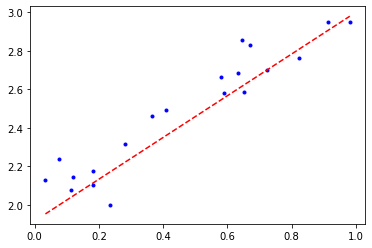

In [22]:
# Plot the learned regression model

plt.plot(x_train, y_train, 'b.')

x_linear_regression=np.linspace(min(x_train), max(x_train), 50)
plt.plot(x_linear_regression, lin_reg(x_linear_regression).numpy(), 'r--')
plt.show()

In [23]:
grad_hist = np.array([[x[0].numpy().squeeze(), x[1].numpy().squeeze()]for x in grad_hist])
lr_hist = np.array(lr_hist)
weight_hist = np.array(weight_hist)
bias_hist = np.array(bias_hist)
loss_hist = np.array(loss_hist)

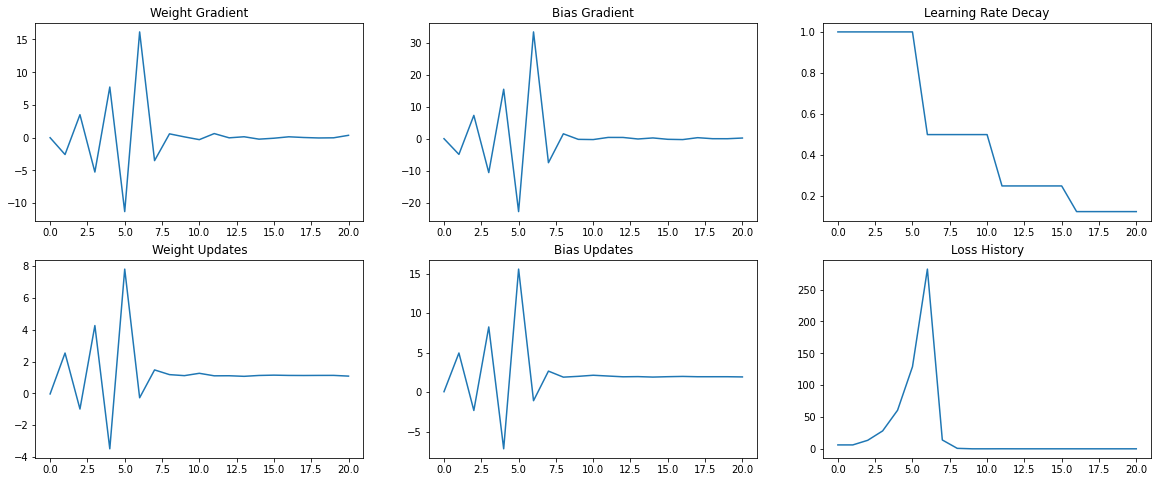

In [24]:
plt.figure(figsize=(20,8))

plt.subplot(2, 3, 1)
plt.plot(grad_hist[:,0])
plt.title("Weight Gradient")

plt.subplot(2, 3, 2)
plt.plot(grad_hist[:,1])
plt.title("Bias Gradient")

plt.subplot(2, 3, 3)
plt.plot(lr_hist)
plt.title("Learning Rate Decay")

plt.subplot(2, 3, 4)
plt.plot(weight_hist)
plt.title("Weight Updates")

plt.subplot(2, 3, 5)
plt.plot(bias_hist)
plt.title("Bias Updates")

plt.subplot(2, 3, 6)
plt.plot(loss_hist)
plt.title("Loss History")

plt.show()

***
<a id="coding_tutorial_4"></a>
## Custom training loops

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [26]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax, InputLayer

In [27]:
# Define the custom layers and model

class MyLayer(Layer):
    def __init__(self, units, **kwargs):
        super(MyLayer, self).__init__(**kwargs)
        self.units = units    

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), 
                                 initializer="random_normal",
                                 name="KERNEL",
                                 trainable=True)
        self.b = self.add_weight(shape=(self.units,), 
                                 initializer="zeros", 
                                 name="BIAS",
                                 trainable=True)

    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


class MyDropout(Layer):
    def __init__(self, rate, **kwargs):
        super(MyDropout, self).__init__(**kwargs)
        self.rate = rate
        
    def call(self, inputs):
        mask = tf.constant(np.random.choice([0,1], size=inputs.shape, p=[self.rate, 1-self.rate]), dtype=tf.float32)
        return mask*inputs


class MyModel(Model):
    def __init__(self, units_1, units_2, units_3):
        super(MyModel, self).__init__()
        self.input_1 = InputLayer()
        self.dense_1 = MyLayer(units=units_1)
        self.dropout_1 = MyDropout(rate=0.5)
        self.dense_2 = MyLayer(units=units_2)
        self.dropout_2 = MyDropout(rate=0.2)
        self.dense_3 = MyLayer(units=units_3)
        self.softmax = Softmax()

    def call(self, inputs):
        h = self.input_1(inputs)
        h = self.dense_1(h)
        h = tf.nn.relu(h)
        h = self.dropout_1(h)
        h = self.dense_2(h)
        h = tf.nn.relu(h)
        h = self.dropout_2(h)
        h = self.dense_3(h)
        return self.softmax(h)

In [28]:
model = MyModel(units_1 = 64,
                units_2=64,
                units_3=46)

print(model(tf.ones((1, 10000))).numpy(), 
      end="\n\n")
model.summary()

[[0.02190958 0.02310297 0.02691157 0.02252023 0.01768259 0.02147809
  0.02076296 0.02474516 0.01945765 0.02368741 0.02251086 0.02129038
  0.02754266 0.01970401 0.02237848 0.01628769 0.02179141 0.01913401
  0.02235663 0.02005829 0.02096008 0.0217981  0.01845257 0.02154999
  0.01996044 0.02228064 0.01889768 0.02301552 0.02224897 0.02169374
  0.02387324 0.02426462 0.02344438 0.01872711 0.01963631 0.02147097
  0.02449348 0.01957655 0.02453465 0.01805585 0.0208967  0.02634856
  0.02083642 0.02627058 0.02173284 0.01966748]]

Model: "my_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [None]                    0         
_________________________________________________________________
my_layer_4 (MyLayer)         multiple                  640064    
_________________________________________________________________
my_dropout_3 (MyDropout)     multiple                  0   

#### Load the reuters dataset and define the class_names 

In [29]:
# Load the dataset

from tensorflow.keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

class_names = ['cocoa','grain','veg-oil','earn','acq','wheat','copper','housing','money-supply',
   'coffee','sugar','trade','reserves','ship','cotton','carcass','crude','nat-gas',
   'cpi','money-fx','interest','gnp','meal-feed','alum','oilseed','gold','tin',
   'strategic-metal','livestock','retail','ipi','iron-steel','rubber','heat','jobs',
   'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead']

2113536/2110848 [==============================] - 0s 0us/step


In [30]:
# Print the class of the first sample

print("Label: {}".format(class_names[train_labels[0]]))

Label: earn


#### Get the dataset word index

In [31]:
# Load the Reuters word index

word_to_index = reuters.get_word_index()

invert_word_index = dict([(value, key) for (key, value) in word_to_index.items()])
text_news = ' '.join([invert_word_index.get(i - 3, '?') for i in train_data[0]])

557056/550378 [==============================] - 0s 0us/step


In [32]:
# Print the first data example sentence

text_news

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

#### Preprocess the data

In [33]:
# Define a function that encodes the data into a 'bag of words' representation

def bag_of_words(text_samples, elements=10000):
    output = np.zeros((len(text_samples), elements))
    for i, word in enumerate(text_samples):
        output[i, word] = 1.
    return output

x_train = bag_of_words(train_data)
x_test = bag_of_words(test_data)

print("Shape of x_train:", x_train.shape)
print("Shape of x_test:", x_test.shape)

Shape of x_train: (8982, 10000)
Shape of x_test: (2246, 10000)


#### Define the loss function and optimizer



In [34]:
# Define the categorical cross entropy loss and Adam optimizer

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

def loss(model, x, y, wd):
    kernel_variables = []
    for l in model.layers:
        for w in l.weights:
            if 'kernel' in w.name.lower():
                kernel_variables.append(w)
    wd_penalty = wd * tf.reduce_sum([tf.reduce_sum(tf.square(k)) for k in kernel_variables])
    y_ = model(x)
    return loss_object(y_true=y, y_pred=y_) + wd_penalty

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

#### Train the model

In [35]:
# Define a function to compute the forward and backward pass

def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [36]:
# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

# Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# Training History
train_accuracy_results = []
train_loss_results = []

# Hyperparametrs
num_epochs = 10
weight_decay = 0.005

# Training Loop

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    for x,y in train_dataset:
        loss_val, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        epoch_loss_avg(loss_val)
        epoch_accuracy(to_categorical(y), model(x))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch: {:03d}\t\tLoss: {:0.6f}".format(epoch+1, train_loss_results[-1]))

print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 001		Loss: 3.311863
Epoch: 002		Loss: 1.965279
Epoch: 003		Loss: 1.919165
Epoch: 004		Loss: 1.883233
Epoch: 005		Loss: 1.861961
Epoch: 006		Loss: 1.860613
Epoch: 007		Loss: 1.842500
Epoch: 008		Loss: 1.838994
Epoch: 009		Loss: 1.829128
Epoch: 010		Loss: 1.822883
Duration :135.478


#### Evaluate the model

In [37]:
# Create a Dataset object for the test set

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, test_labels))
test_dataset = test_dataset.batch(32)

In [38]:
# Collect average loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [39]:
# Loop over the test set and print scores

from tensorflow.keras.utils import to_categorical

for x, y in test_dataset:
    # Optimize the model
    loss_value = loss(model, x, y, weight_decay)    
    # Compute current loss
    epoch_loss_avg(loss_value)  
    # Compare predicted label to actual label
    epoch_accuracy(to_categorical(y), model(x))

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 1.915
Test accuracy: 66.251%


#### Plot the learning curves

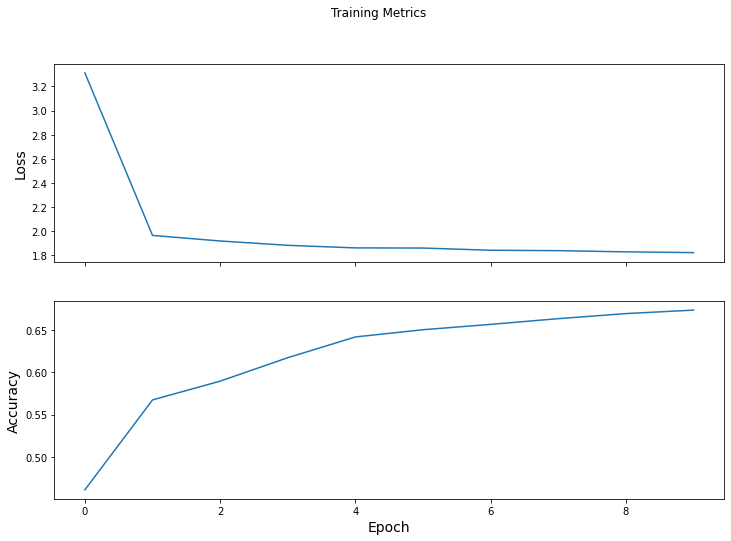

In [40]:
# Plot the training loss and accuracy

fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)

axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Predict from the model

In [41]:
# Get the model prediction for an example input

predicted_label = np.argmax(model(x_train[np.newaxis,0]),axis=1)[0]
print("Prediction: {}".format(class_names[predicted_label]))
print("     Label: {}".format(class_names[train_labels[0]]))

Prediction: earn
     Label: earn


***
<a id="coding_tutorial_5"></a>
## tf.function decorator

In [42]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Softmax
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
import time

#### Build the model

In [43]:
# Initialize a new model

model = MyModel(units_1 = 64,
                units_2=64,
                units_3=46)

#### Redefine the grad function using the @tf.function decorator

In [44]:
# Use the @tf.function decorator

@tf.function
def grad(model, inputs, targets, wd):
    with tf.GradientTape() as tape:
        loss_value = loss(model, inputs, targets, wd)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

#### Train the model

In [45]:
# Re-run the training loop

# Implement the training loop

from tensorflow.keras.utils import to_categorical

start_time = time.time()

# Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_labels))
train_dataset = train_dataset.batch(32)

# Training History
train_accuracy_results = []
train_loss_results = []

# Hyperparametrs
num_epochs = 10
weight_decay = 0.005

# Training Loop

for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    for x,y in train_dataset:
        loss_val, grads = grad(model, x, y, weight_decay)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        epoch_loss_avg(loss_val)
        epoch_accuracy(to_categorical(y), model(x))

    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    print("Epoch: {:03d}\t\tLoss: {:0.6f}".format(epoch+1, train_loss_results[-1]))

print("Duration :{:.3f}".format(time.time() - start_time))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch: 001		Loss: 2.369287
Epoch: 002		Loss: 1.877493
Epoch: 003		Loss: 1.793881
Epoch: 004		Loss: 1.740616
Epoch: 005		Loss: 1.698137
Epoch: 006		Loss: 1.668248
Epoch: 007		Loss: 1.645067
Epoch: 008		Loss: 1.627515
Epoch: 009		Loss: 1.613955
Epoch: 010		Loss: 1.600988
Duration :67.559


#### Print the autograph code

In [46]:
# Use tf.autograph.to_code to see the generated code

print(tf.autograph.to_code(grad.python_function))

def tf__grad(model, inputs, targets, wd):
    with ag__.FunctionScope('grad', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
        do_return = False
        retval_ = ag__.UndefinedReturnValue()
        with ag__.ld(tf).GradientTape() as tape:
            loss_value = ag__.converted_call(ag__.ld(loss), (ag__.ld(model), ag__.ld(inputs), ag__.ld(targets), ag__.ld(wd)), None, fscope)
        try:
            do_return = True
            retval_ = (ag__.ld(loss_value), ag__.converted_call(ag__.ld(tape).gradient, (ag__.ld(loss_value), ag__.ld(model).trainable_variables), None, fscope))
        except:
            do_return = False
            raise
        return fscope.ret(retval_, do_return)

